In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


In [2]:
import helpers
import classifier

In [3]:
from torch_geometric.loader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = classifier.LundHGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = classifier.nn.BCEWithLogitsLoss()

In [5]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()

        logits = model(
            data.x,
            data.hyperedge_index,
            data.batch
        )

        loss = criterion(logits, data.y.float())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item() * data.y.size(0)

        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc


In [6]:
def validate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits = model(
                data.x,
                data.hyperedge_index,
                data.batch
            )

            loss = criterion(logits, data.y.float())
            total_loss += loss.item() * data.y.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            correct += (preds == data.y).sum().item()
            total += data.y.size(0)

            all_logits.append(probs.cpu())
            all_labels.append(data.y.cpu())

    all_probs = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_probs)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc, auc


In [7]:
def test(model, loader, device):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits = model(
                data.x,
                data.hyperedge_index,
                data.batch
            )

            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu())
            all_labels.append(data.y.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    return {
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "probs": all_probs,
        "labels": all_labels
    }


In [20]:
signal_graphs = helpers.load_extended_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-validation.json", label=1)
background_graphs = helpers.load_extended_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-validation.json", label=0)

test_signal = helpers.load_extended_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-train.json", label=1)
test_background = helpers.load_extended_json_file("/Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-train.json", label=0)


dataset = signal_graphs + background_graphs
testing = test_signal + test_background

Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-validation.json: 12773it [00:18, 687.13it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-validation.json: 12772it [00:09, 1379.01it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-signal-train.json: 1499it [00:02, 507.60it/s]
Loading /Users/sattwamoghosh/IISER/Sem9/PH5101/g-background-train.json: 1499it [00:01, 1479.72it/s]


In [11]:
train_set, val_set = train_test_split(dataset, test_size=0.25, shuffle=True)

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    val_set,
    batch_size=8,
    shuffle=False
)

test_loader = DataLoader(
    testing,
    # batch_size=8,
    shuffle=True,
)

In [14]:
num_epochs = 300

best_valid_acc = 0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(
        model, train_loader, optimizer, criterion, device
    )


    val_loss, val_acc, val_auc = validate(
        model, val_loader, criterion, device
    )

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss {train_loss:.4f} Acc {train_acc:.3f} | "
        f"Val Loss {val_loss:.4f} Acc {val_acc:.3f} AUC {val_auc:.4f}"
    )

    
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), "classifier.pt")

    print('Current validation acc: %.5f (best: %.5f)' % (val_acc, best_valid_acc))




Epoch 001 | Train Loss 0.4899 Acc 0.799 | Val Loss 0.4715 Acc 0.813 AUC 0.8475
Current validation acc: 0.81337 (best: 0.81337)
Epoch 002 | Train Loss 0.4887 Acc 0.800 | Val Loss 0.4764 Acc 0.814 AUC 0.8481
Current validation acc: 0.81368 (best: 0.81368)
Epoch 003 | Train Loss 0.4885 Acc 0.799 | Val Loss 0.4719 Acc 0.817 AUC 0.8480
Current validation acc: 0.81666 (best: 0.81666)
Epoch 004 | Train Loss 0.4881 Acc 0.801 | Val Loss 0.4698 Acc 0.817 AUC 0.8484
Current validation acc: 0.81713 (best: 0.81713)
Epoch 005 | Train Loss 0.4871 Acc 0.802 | Val Loss 0.4755 Acc 0.815 AUC 0.8489
Current validation acc: 0.81462 (best: 0.81713)
Epoch 006 | Train Loss 0.4855 Acc 0.800 | Val Loss 0.4694 Acc 0.819 AUC 0.8492
Current validation acc: 0.81901 (best: 0.81901)
Epoch 007 | Train Loss 0.4847 Acc 0.802 | Val Loss 0.4691 Acc 0.821 AUC 0.8497
Current validation acc: 0.82089 (best: 0.82089)
Epoch 008 | Train Loss 0.4834 Acc 0.803 | Val Loss 0.4691 Acc 0.820 AUC 0.8503
Current validation acc: 0.82010 

In [19]:
model.load_state_dict(torch.load("classifier.pt", map_location=torch.device(device)))

test_results = test(model, test_loader, device)
print("Test AUC:", test_results["auc"])



Test AUC: 0.8941357836511865


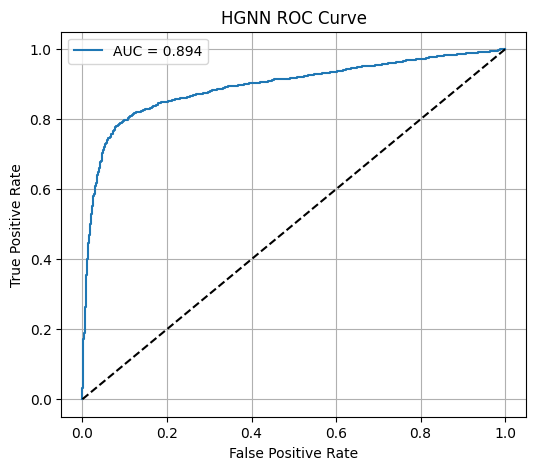

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(
    test_results["fpr"],
    test_results["tpr"],
    label=f"AUC = {test_results['auc']:.3f}"
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("HGNN ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
